In [ ]:
!pip install transformers datasets scikit-learn torch matplotlib seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

In [ ]:
uploaded = files.upload()

Saving Emotion.zip to Emotion.zip


In [ ]:
zip_file_path = '/content/Emotion.zip'
extract_dir = '/content/emotion_dataset/'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extracted_files = os.listdir(extract_dir)
print(f"Extracted Files: {extracted_files}")

Extracted Files: ['validation.csv', 'test.csv', 'training.csv']


In [ ]:
train_file = os.path.join(extract_dir, '/content/emotion_dataset/training.csv')
val_file = os.path.join(extract_dir, '/content/emotion_dataset/validation.csv')
test_file = os.path.join(extract_dir, '/content/emotion_dataset/test.csv')

train_df = pd.read_csv(train_file)
val_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)

print(train_df.head())

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


In [ ]:
uploaded = files.upload()
prompts_file_path = "/content/prompt.csv"
prompts_df = pd.read_csv(prompts_file_path)
print(prompts_df.head())

Saving prompt.csv to prompt.csv
                                                text  label
0       i want each of you to feel my gentle embrace   love
1  i didnt feel safe in my room because the argum...    joy
2  i feel my lip curl up into a half smile amused...    joy
3                           i would still feel weird   fear
4  i feel rude about going to the bathroom when s...  anger


In [ ]:
prompts = prompts_df['text'].tolist()
prompt_labels = prompts_df['label'].tolist()

In [ ]:
model_name = "EleutherAI/pythia-410m"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6).to(device)
if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/911M [00:00<?, ?B/s]

Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/pythia-410m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
label_names = ['sadness (0)', 'joy (1)', 'love (2)', 'anger (3)', 'fear (4)', 'surprise (5)']
def evaluate_with_prompt(model, tokenizer, prompts):
    model.eval()
    results = []

    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)
            pred = torch.argmax(probs, dim=-1).item()
        results.append((prompt, pred, probs.cpu().numpy()))

    return results

In [ ]:
results_before_fine_tuning = evaluate_with_prompt(model, tokenizer, prompts)

for prompt, pred, probs in results_before_fine_tuning:
    print(f"prompt: {prompt}\n predicted label: {label_names[pred]}, probabilities: {probs}\n")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


prompt: i want each of you to feel my gentle embrace
 predicted label: surprise (5), probabilities: [[0.00296284 0.08748253 0.09127391 0.03094156 0.03052031 0.75681883]]

prompt: i didnt feel safe in my room because the argument was going on in my room and things were getting rough
 predicted label: surprise (5), probabilities: [[0.0322592  0.29239997 0.29691377 0.00215281 0.01219372 0.36408052]]

prompt: i feel my lip curl up into a half smile amused at the way he s put it
 predicted label: joy (1), probabilities: [[0.01169337 0.73180264 0.02557864 0.00650724 0.02466696 0.19975112]]

prompt: i would still feel weird
 predicted label: joy (1), probabilities: [[0.00905562 0.64015675 0.04202826 0.00673463 0.0094398  0.29258487]]

prompt: i feel rude about going to the bathroom when she s in there
 predicted label: surprise (5), probabilities: [[0.00475634 0.18912925 0.2920087  0.00642627 0.01626285 0.49141654]]

prompt: I feel so heartbroken and overwhelmed with sadness
 predicted label:

In [ ]:
def tokenize_text(tokenizer, texts, labels):
    tokenized = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    tokenized['labels'] = torch.tensor(labels)
    return tokenized

In [ ]:
train_texts, train_labels = train_df['text'].tolist(), train_df['label'].tolist()
val_texts, val_labels = val_df['text'].tolist(), val_df['label'].tolist()

train_data = tokenize_text(tokenizer, train_texts, train_labels)
val_data = tokenize_text(tokenizer, val_texts, val_labels)

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, tokenized_data):
        self.data = tokenized_data

    def __len__(self):
        return len(self.data['labels'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.data.items()}

# Dataloader
train_loader = DataLoader(EmotionDataset(train_data), batch_size=16, shuffle=True)
val_loader = DataLoader(EmotionDataset(val_data), batch_size=16, shuffle=False)

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)
num_training_steps = len(train_loader) * 5
scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 5
model.train()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    for batch in tqdm(train_loader, desc="Training"):
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Loss after epoch {epoch + 1}: {loss.item():.4f}")

Epoch 1


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss after epoch 1: 0.4043
Epoch 2


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss after epoch 2: 0.4989
Epoch 3


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss after epoch 3: 0.0687
Epoch 4


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss after epoch 4: 0.0088
Epoch 5


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss after epoch 5: 0.0055


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            preds.append(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
            labels.append(batch['labels'].cpu().numpy())

    preds = np.concatenate(preds)
    labels = np.concatenate(labels)
    return preds, labels

val_preds, val_labels = evaluate_model(model, val_loader)

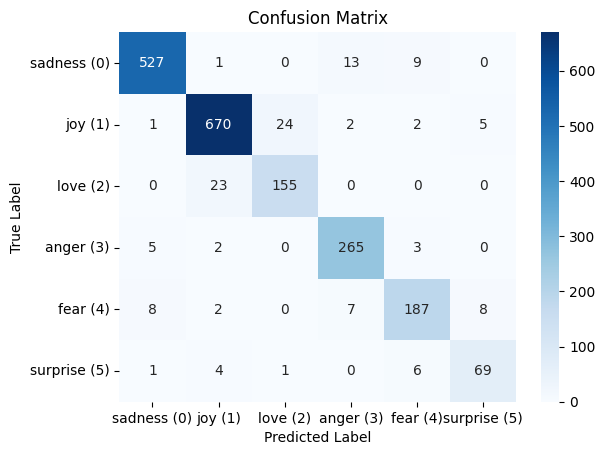

In [ ]:
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
print(classification_report(val_labels, val_preds, target_names=label_names))

              precision    recall  f1-score   support

 sadness (0)       0.97      0.96      0.97       550
     joy (1)       0.95      0.95      0.95       704
    love (2)       0.86      0.87      0.87       178
   anger (3)       0.92      0.96      0.94       275
    fear (4)       0.90      0.88      0.89       212
surprise (5)       0.84      0.85      0.85        81

    accuracy                           0.94      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.94      0.94      0.94      2000



In [ ]:
macro_f1 = f1_score(val_labels, val_preds, average='macro')
weighted_f1 = f1_score(val_labels, val_preds, average='weighted')
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Macro F1 Score: 0.9111
Weighted F1 Score: 0.9365


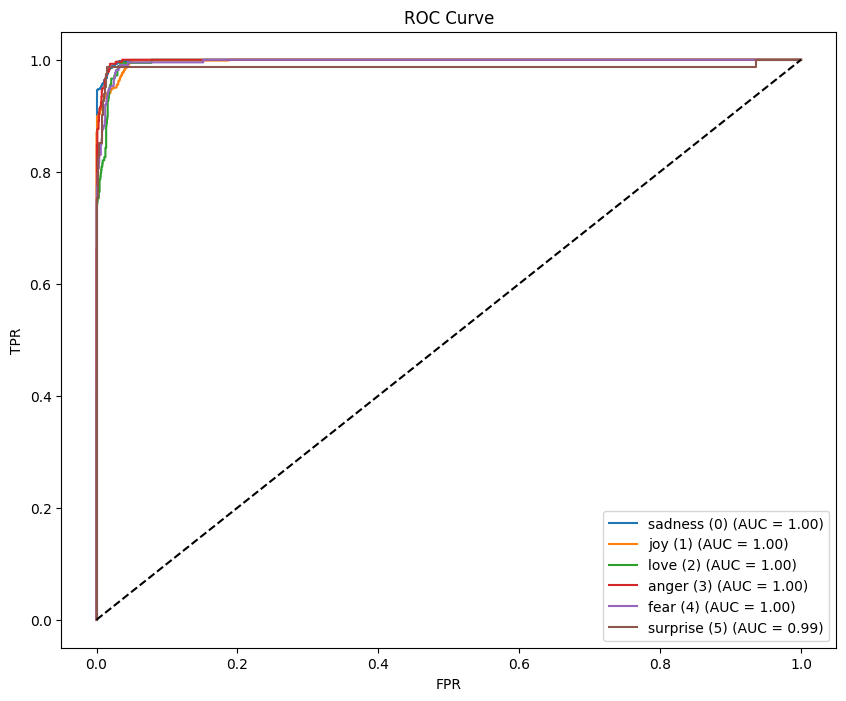

In [ ]:
val_probs = np.concatenate([
    torch.softmax(model(**{key: val.to(device) for key, val in batch.items()}).logits, dim=-1).detach().cpu().numpy()
    for batch in val_loader
], axis=0)

fpr, tpr, roc_auc = {}, {}, {}

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve((val_labels == i).astype(int), val_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label=f"{label_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.show()

In [ ]:
results_after_fine_tuning = evaluate_with_prompt(model, tokenizer, prompts)
for prompt, pred, probs in results_after_fine_tuning:
    print(f"prompt: {prompt}\n predicted label: {label_names[pred]}, probabilities: {probs}\n")

prompt: i want each of you to feel my gentle embrace
 predicted label: love (2), probabilities: [[1.5425760e-08 9.9551949e-09 9.9999952e-01 2.7279054e-07 2.2042050e-07
  8.2251962e-11]]

prompt: i didnt feel safe in my room because the argument was going on in my room and things were getting rough
 predicted label: joy (1), probabilities: [[1.06066636e-07 9.99998093e-01 3.00552614e-07 1.03391997e-08
  1.54011332e-06 1.38156002e-08]]

prompt: i feel my lip curl up into a half smile amused at the way he s put it
 predicted label: joy (1), probabilities: [[6.2463715e-11 9.9999976e-01 2.3586276e-07 5.6272185e-11 2.3866589e-10
  3.6812654e-08]]

prompt: i would still feel weird
 predicted label: fear (4), probabilities: [[1.2786275e-04 1.2753881e-04 6.4377542e-05 1.0472623e-04 6.4420056e-01
  3.5537493e-01]]

prompt: i feel rude about going to the bathroom when she s in there
 predicted label: anger (3), probabilities: [[8.0434998e-10 3.4101046e-09 9.5990549e-09 1.0000000e+00 9.4571950e-09


In [ ]:
emotion_to_index = {name.split(' ')[0]: idx for idx, name in enumerate(label_names)}
mapped_prompt_labels = [emotion_to_index[label] for label in prompt_labels]

before_preds = [pred for _, pred, _ in results_before_fine_tuning]
after_preds = [pred for _, pred, _ in results_after_fine_tuning]

accuracy_before = accuracy_score(mapped_prompt_labels, before_preds)
accuracy_after = accuracy_score(mapped_prompt_labels, after_preds)

print(f"Accuracy Before Fine-Tuning: {accuracy_before:.4f}")
print(f"Accuracy After Fine-Tuning: {accuracy_after:.4f}")

Accuracy Before Fine-Tuning: 0.1300
Accuracy After Fine-Tuning: 0.9600
